# *Tutorial: Multi-Channel Light Simulation with RGB in Pado 🌊*
**Author:** Dong-Ha Shin | **Last Updated:** 2025-03-19

This tutorial extends the concepts from `1.1_Pado_fundamentals` notebook to work with multi-channel light fields, with a focus on RGB (Red, Green, Blue) color channels

---

In your project folder, put the folder of pado like below
- YOUR PROJECT FOLDER
  - pado
    - light.py
    - optical_element.py
    - propagator.py
    - ...

In [1]:
cd ../..

c:\Users\yilin\pado


In [2]:
pwd

'c:\\Users\\yilin\\pado'

## **🌊 Step 1: import Pado**
First, you should import `Pado`. Make sure to install all the dependency :) 

In [3]:
import pado
import torch
import matplotlib.pyplot as plt

from pado.math import nm, um

# **🌈 Step 2: Multi-Channel Light Simulation**

The fundamental element of `Pado` is `light`, and in this tutorial we'll focus on working with multiple color channels (RGB). We'll simulate how light waves of `different wavelengths` interact with `optical elements` and propagate in free space. In `Pado`, we represent each color channel as a separate 2D complex-valued field on a virtual plane, where each complex value represents both the phase and amplitude of that color's light wave at that spatial location.
For RGB simulation, we need to define three channels with different wavelengths. Let's first set up the resolution parameters for our multi-channel light field:

In [4]:
R = 1000  # number of rows
C = 1000  # number of columns
pitch = 2*um  # physical size of each pixel

# For RGB image simulation, wavelengths are listed in descending order (R: 660nm, G: 521nm, B: 445nm)
wvl = [660*nm, 521*nm, 445*nm]  # wavelengths of the light
dim = (1, 3, R, C)  # dimension of the light [batch, channel, row, column], 3 channels for R-G-B

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(f'Device: {device}')

Device: cpu


Now let's define our light field. Using the `Light` class, we can easily create a light field with the dimensions and parameters we defined above (1000x1000 pixels, 2μm pitch, RGB wavelengths). By default, it initializes as a plane wave with amplitude of 1 and phase of 0. As specified in our device variable, we'll utilize GPU acceleration if available. The light field can be visualized using the `visualize()` function, and you can view specific color channels by specifying the channel index, e.g., `light.visualize(c=0)` for the red channel.

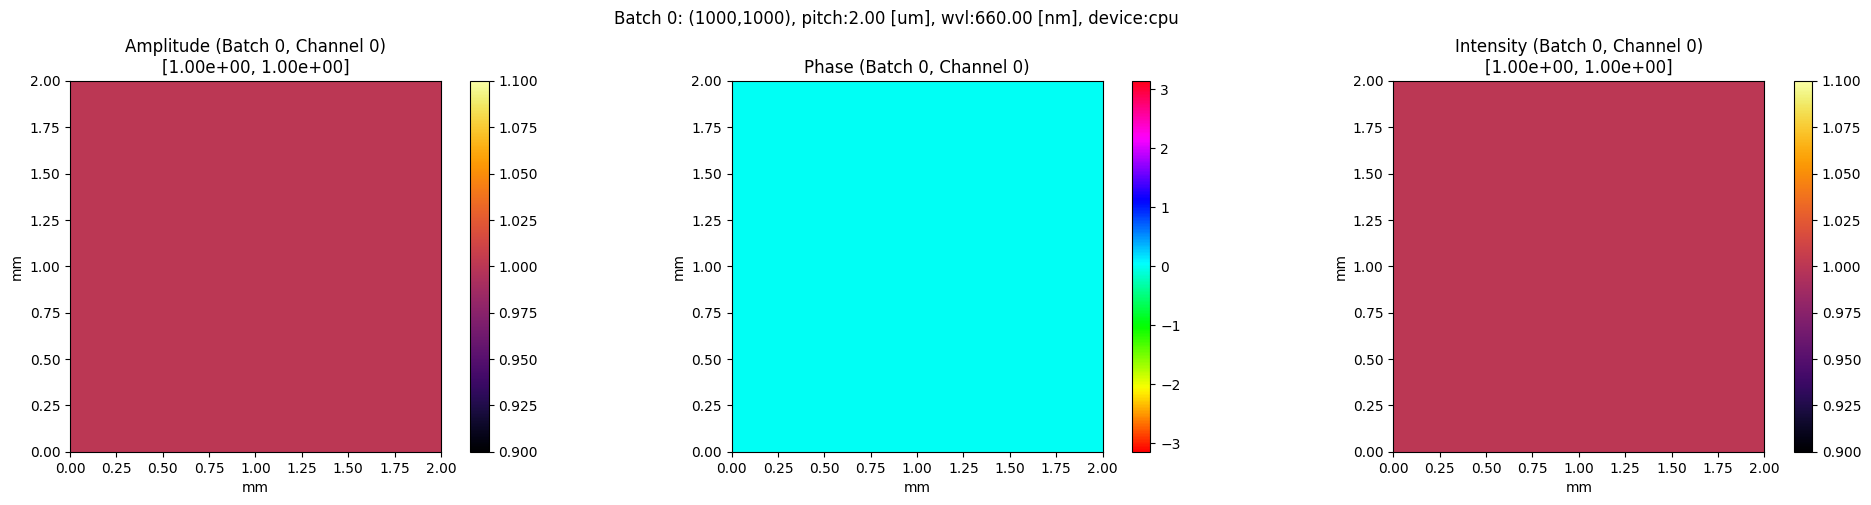

In [5]:
light = pado.light.Light(dim,pitch,wvl,device=device)
light.visualize(c=0)

## **🔭 Step 3: build your own imaging/display system**
In this tutorial, we will use a simple camera with a `refractive lens` and an `aperture`. The `lens` we'll use here is based on geometric optics principles rather than diffraction effects. For each RGB channel, we'll create a separate ideal thin lens that focuses light according to its wavelength. Note that we provide various `optical elements` that can interact with and transform `light` wave. Let's first define the basic optical elements: `lens` and `aperture`.

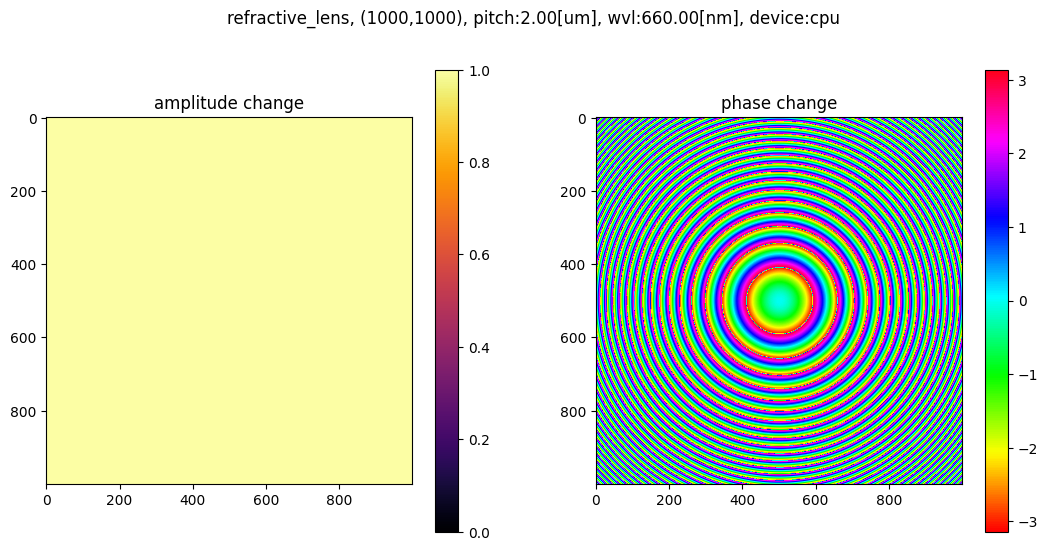

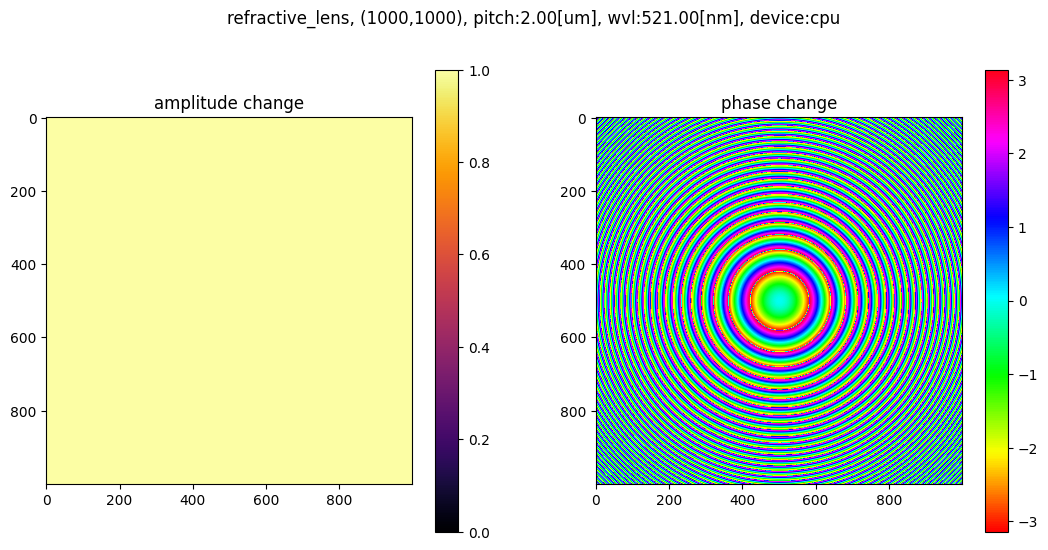

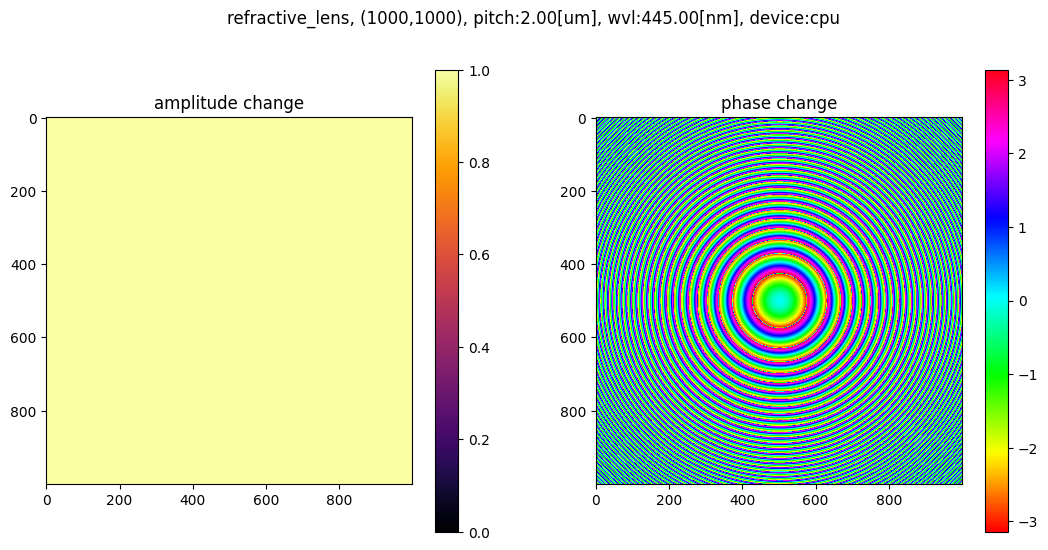

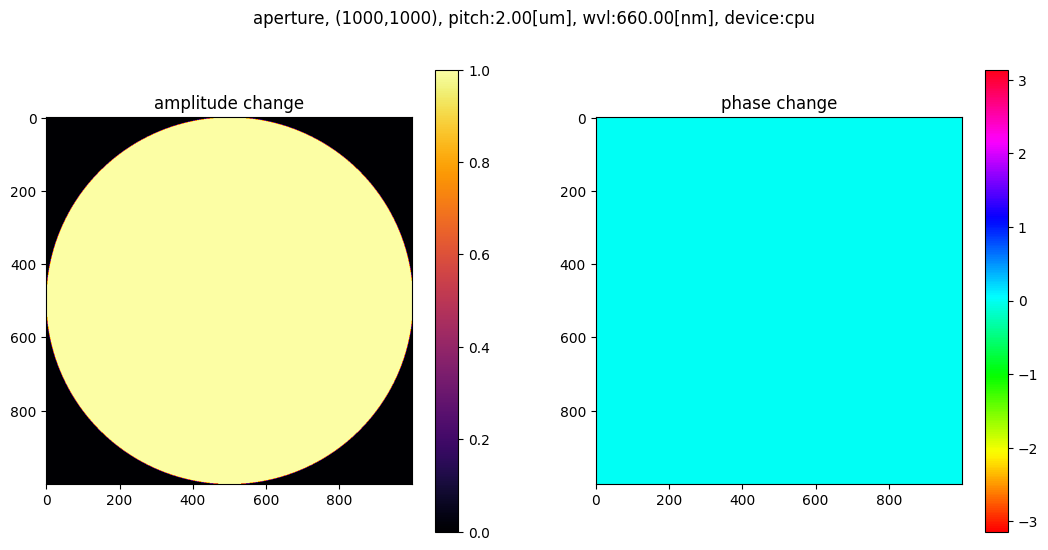

In [6]:
f = 50e-3  # focal length
lens = pado.optical_element.RefractiveLens(dim,pitch,f,wvl,device)
lens.visualize() 
aperture = pado.optical_element.Aperture(dim, pitch, R*pitch, 'circle', wvl, device)
aperture.visualize(c=0) 


Now, we want to simulate the point spread function (PSF) of this camera. In order to do this, we should use light, lens, aperture, and also propagator. The propagator computes how phase and amplitude of light changes after free-space propagation by a specific distance. Specifically, we use Fresnel propagator which is valid for short propagation distances.

In [7]:
prop = pado.propagator.Propagator('Fresnel')

Let's combine everything together and simulate the system's PSF now. Key here is the function `forward` that takes the light and outputs the light after interaction with either the optical element or the propagator. Note that `visualize_image()` is particularly useful here as it combines all RGB channels into a single full-color image, making it easier to observe how the light changes through each optical element.

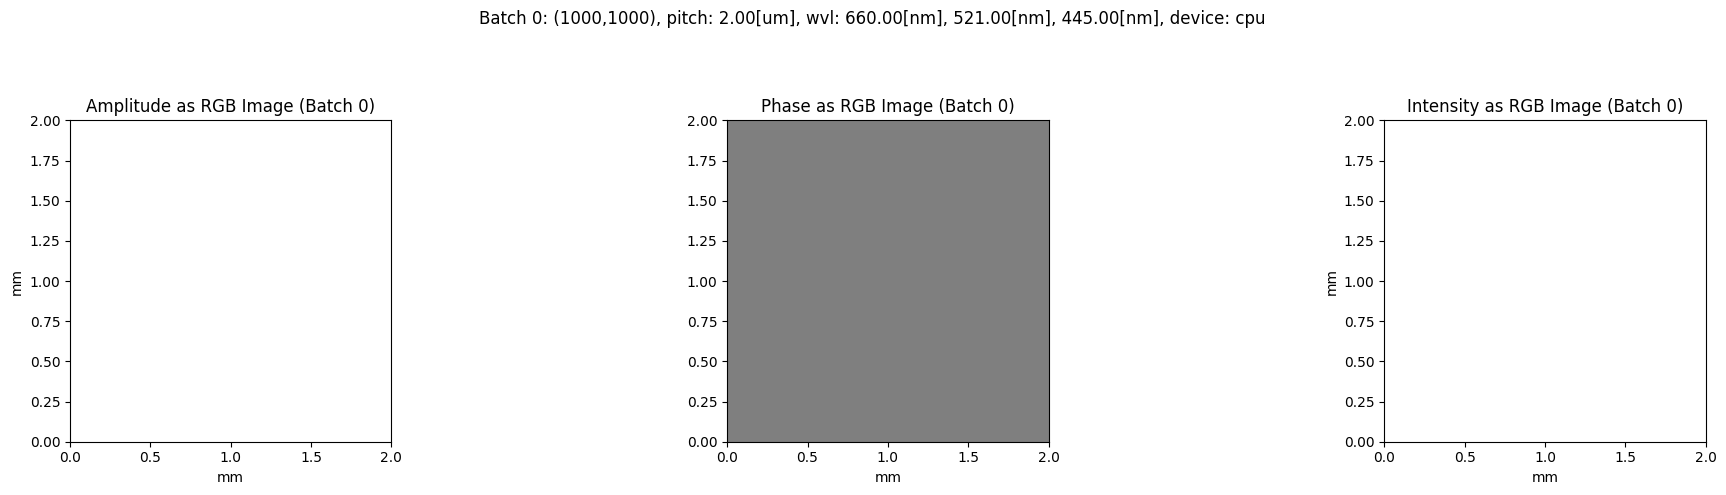

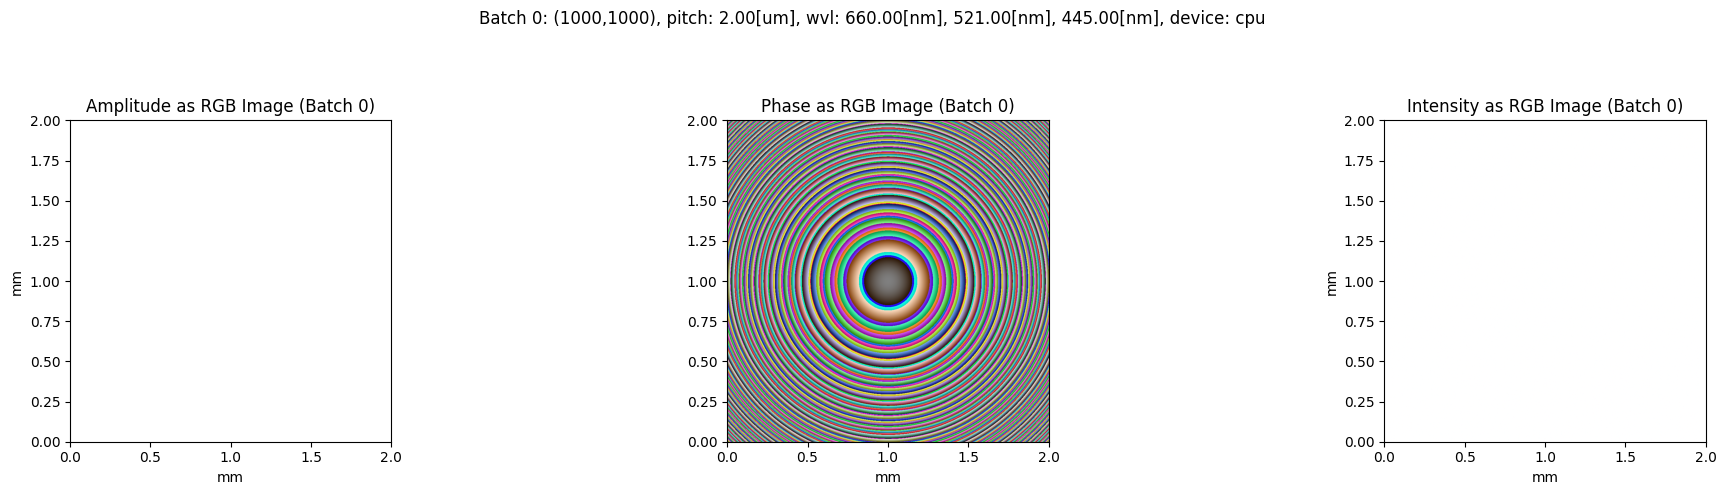

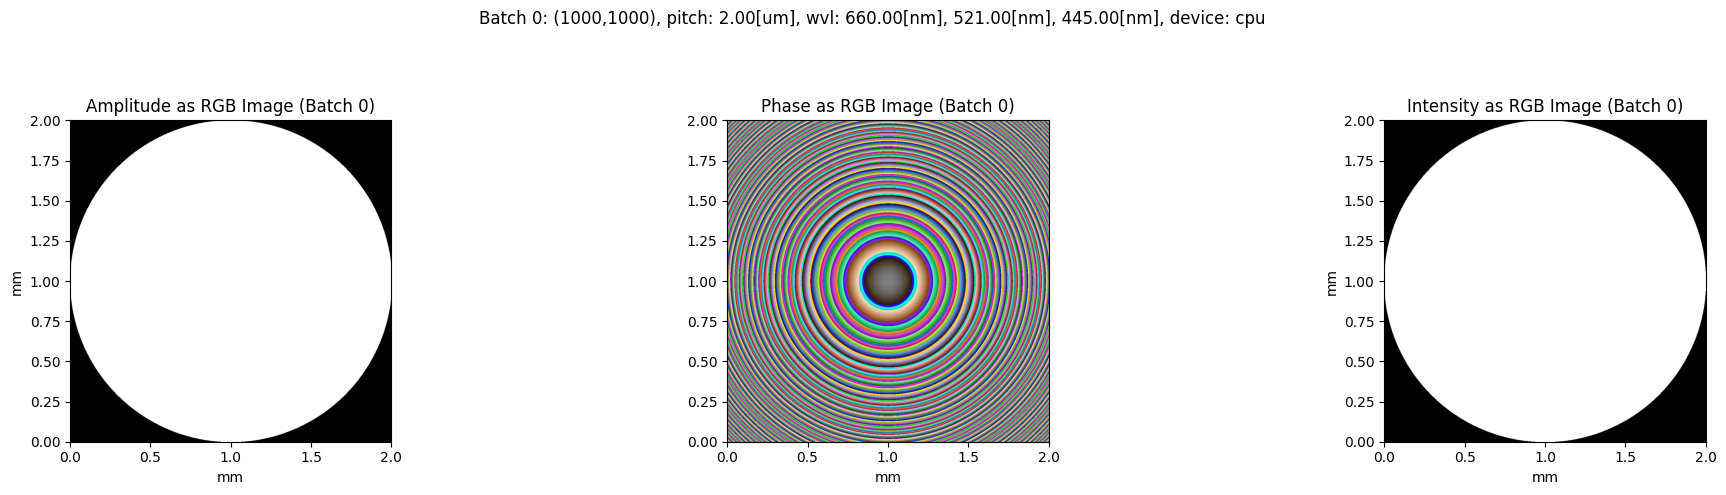

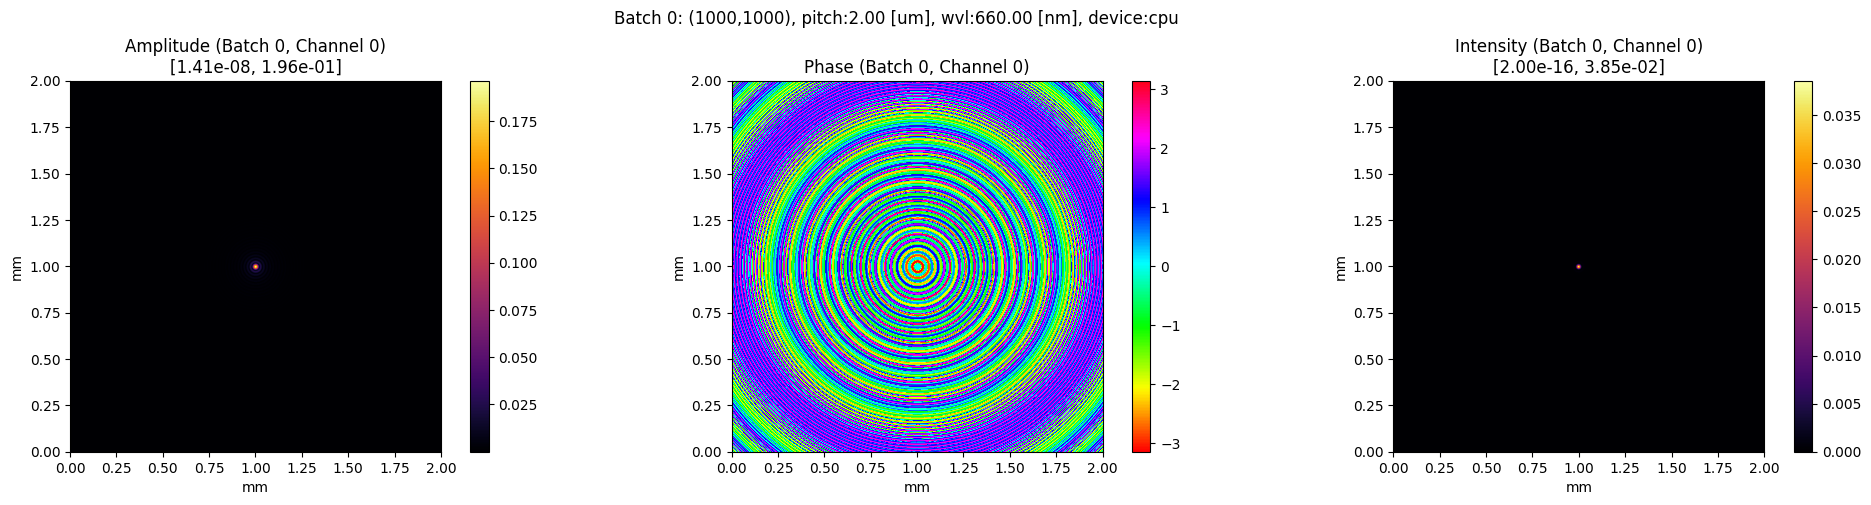

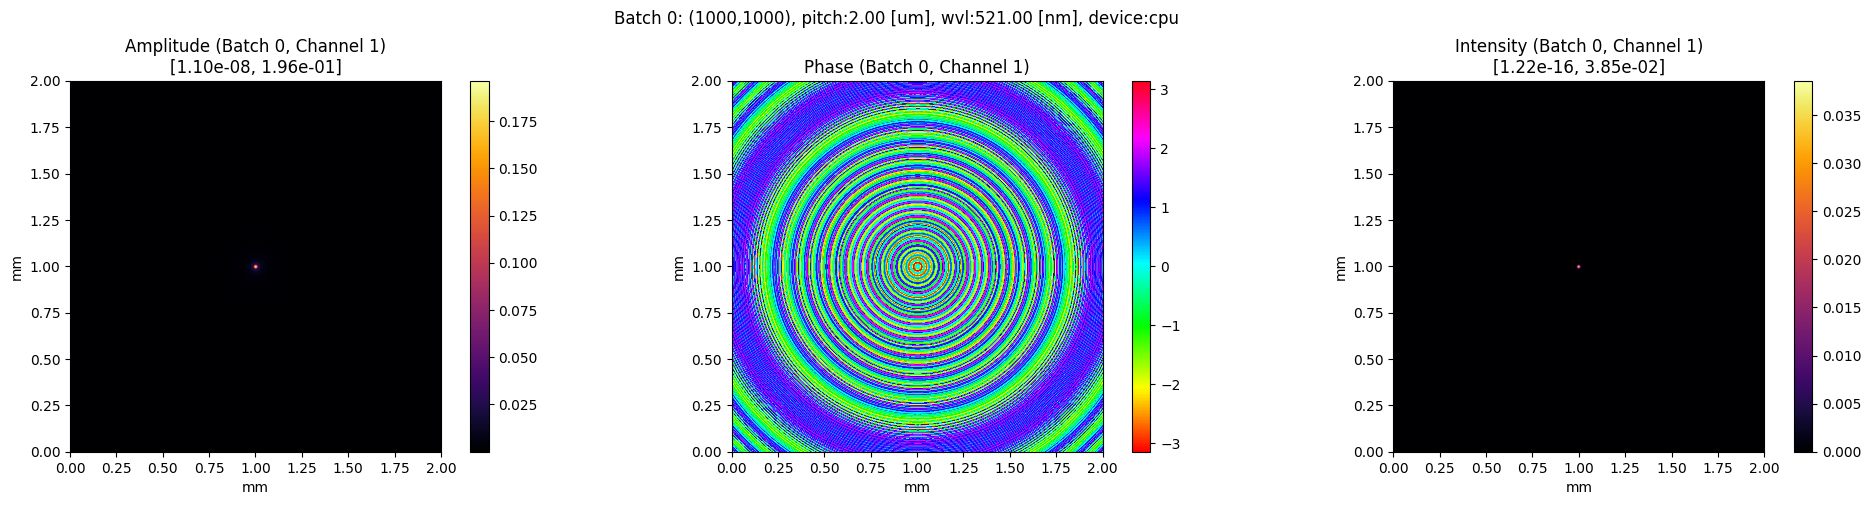

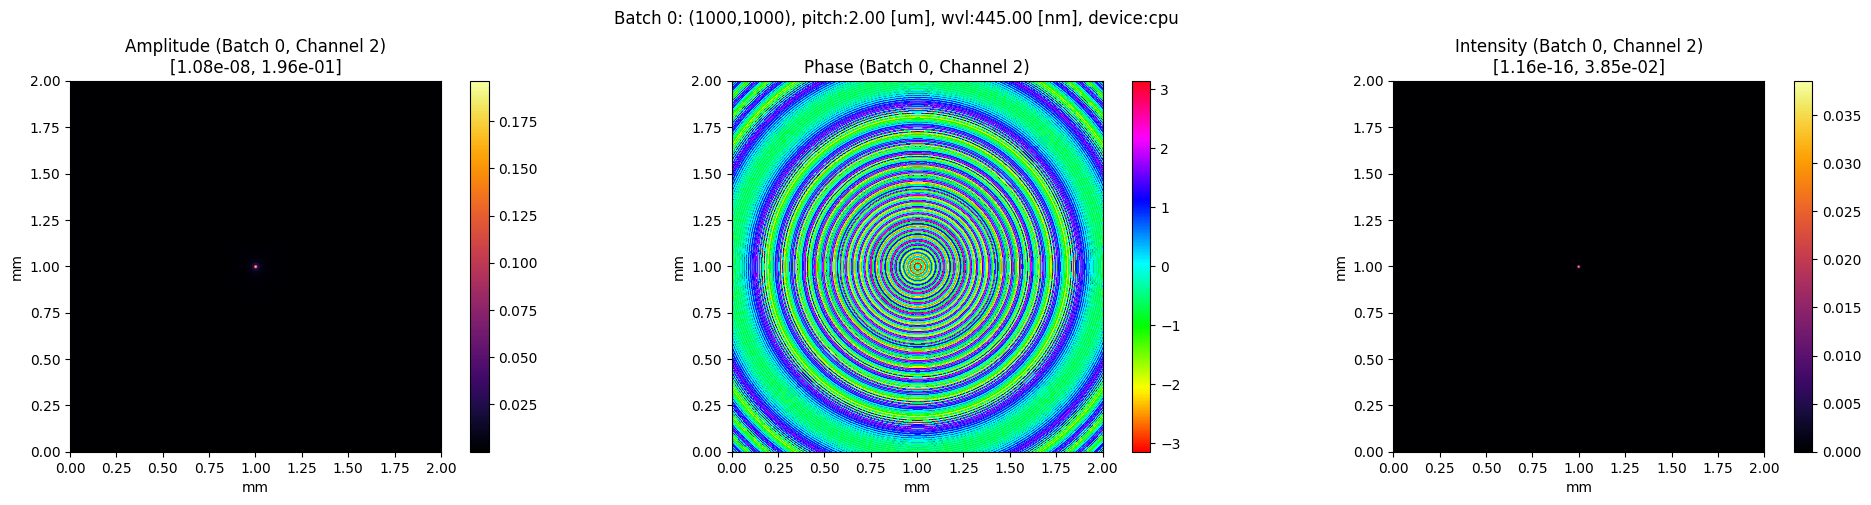

In [8]:
light.visualize_image() 

light_after_lens = lens.forward(light)
light_after_lens.visualize_image() 

light_after_aperture = aperture.forward(light_after_lens)
light_after_aperture.visualize_image() 

light_after_prop = prop.forward(light_after_aperture, f)
light_after_prop.visualize(uniform_scale=False)

## **📸Step 4 : distance varying PSF**
Now we'll explore how the `Point Spread Function (PSF)` changes as the distance between the lens and sensor varies. When the sensor is precisely at the focal distance, the PSF appears as a diffraction-limited focused dot. As we move away from the focal plane, we can observe how the PSF broadens and defocuses, which is critical for understanding depth effects in imaging systems.

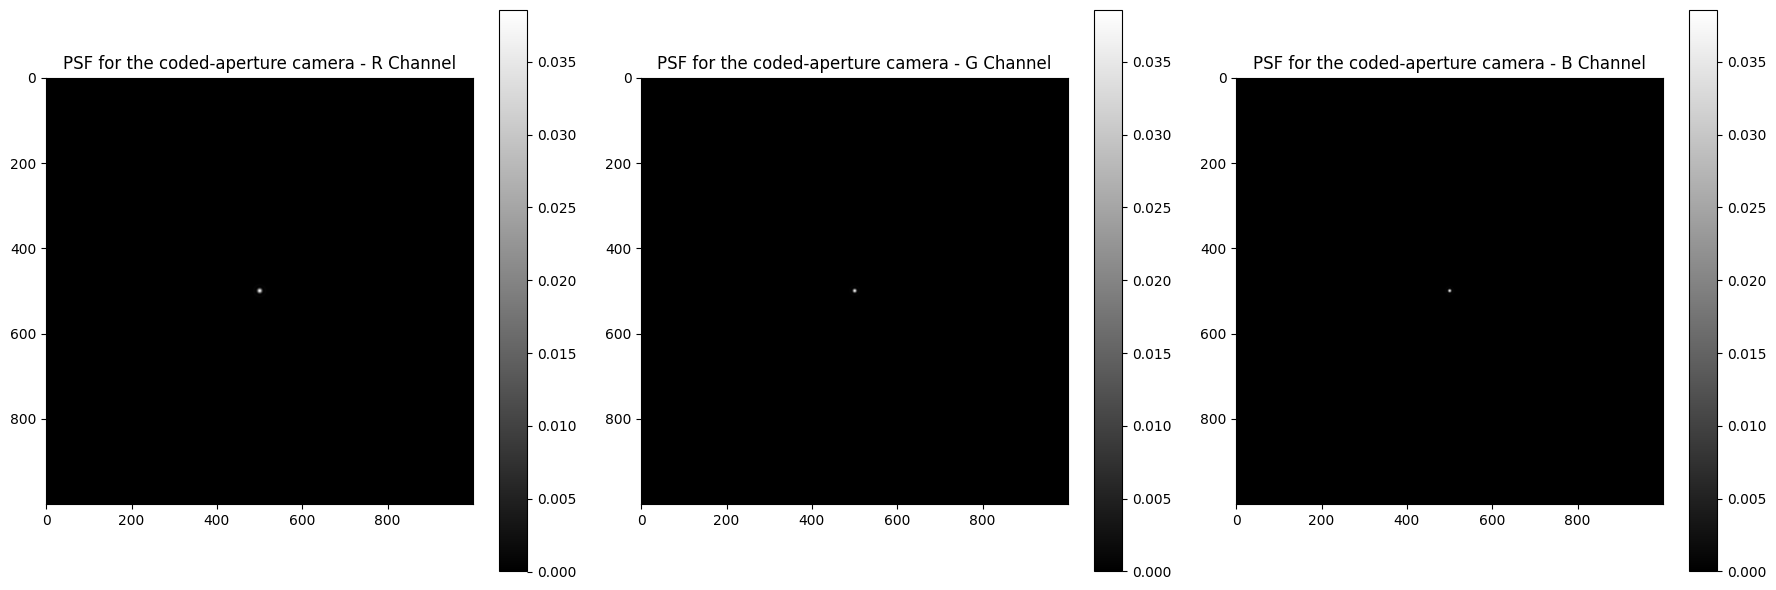

In [9]:
PSF = light_after_prop.get_intensity()
channels = [('R', 0), ('G', 1), ('B', 2)]

plt.figure(figsize=(18, 6)) 

for i, (color, idx) in enumerate(channels):
    plt.subplot(1, 3, i + 1) 
    PSF_channel = PSF[:, idx, ...].data.cpu().squeeze() 
    plt.imshow(PSF_channel, cmap='gray') 
    plt.colorbar() 
    plt.title(f'PSF for the coded-aperture camera - {color} Channel') 

plt.tight_layout() 
plt.show() 


Now, let's make the rendering pipeline as a function so that we can easily call it later. Here, we parameterize the render function with two input parameters of the distance from the lens to the sensor and the aperture's amplitude change profile.

In [10]:
def render(lens2sensor_d, aperture_amp_modulation):
    light = pado.light.Light(dim,pitch,wvl,device=device)
    light_after_lens = lens.forward(light)
    aperture.set_amplitude_change(aperture_amp_modulation)
    light_after_aperture = aperture.forward(light_after_lens)
    light_after_prop = prop.forward(light_after_aperture, lens2sensor_d)
    PSF = light_after_prop.get_intensity()
    return PSF

Let's see how the PSF change for the varying distance between the lens and the sensor. We can observe the differences in PSF changes across RGB channels side by side, which helps us understand the wavelength-dependent behavior.

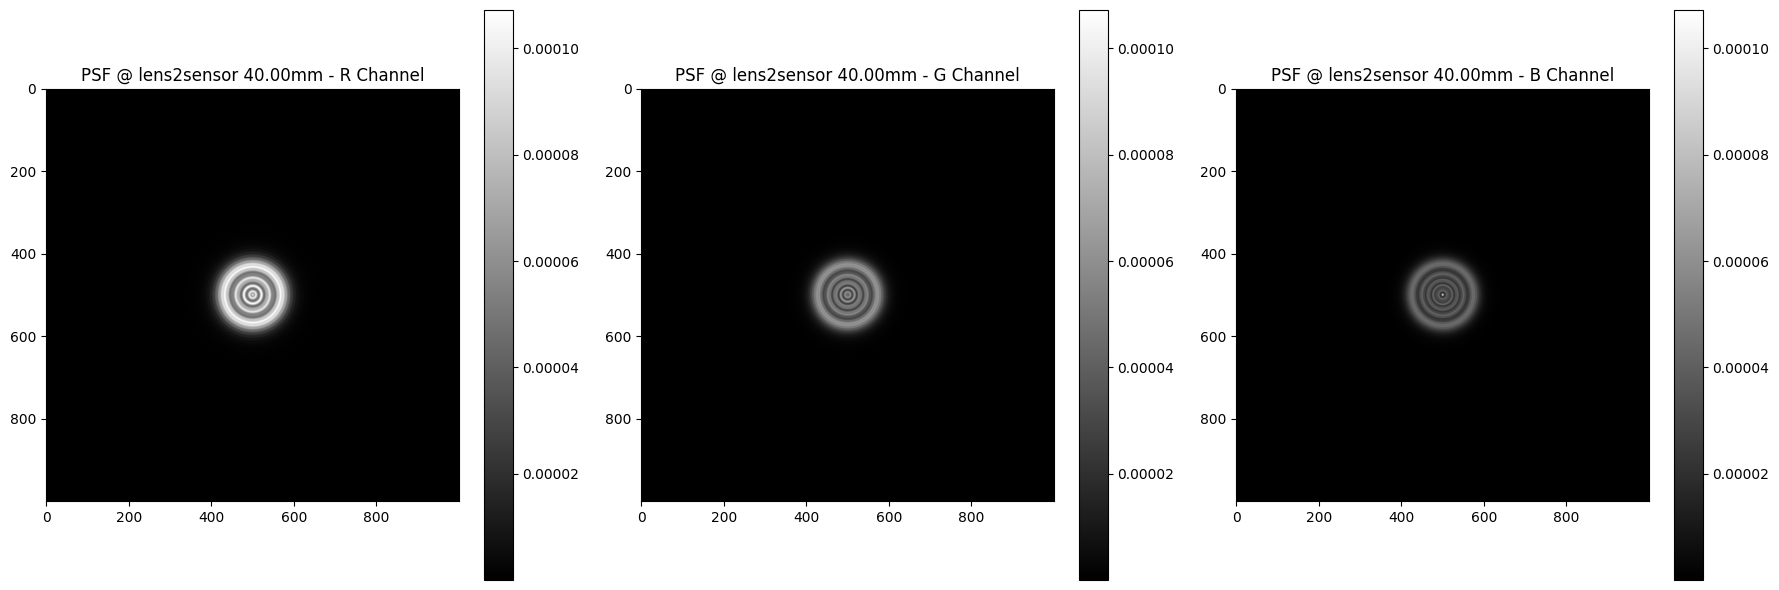

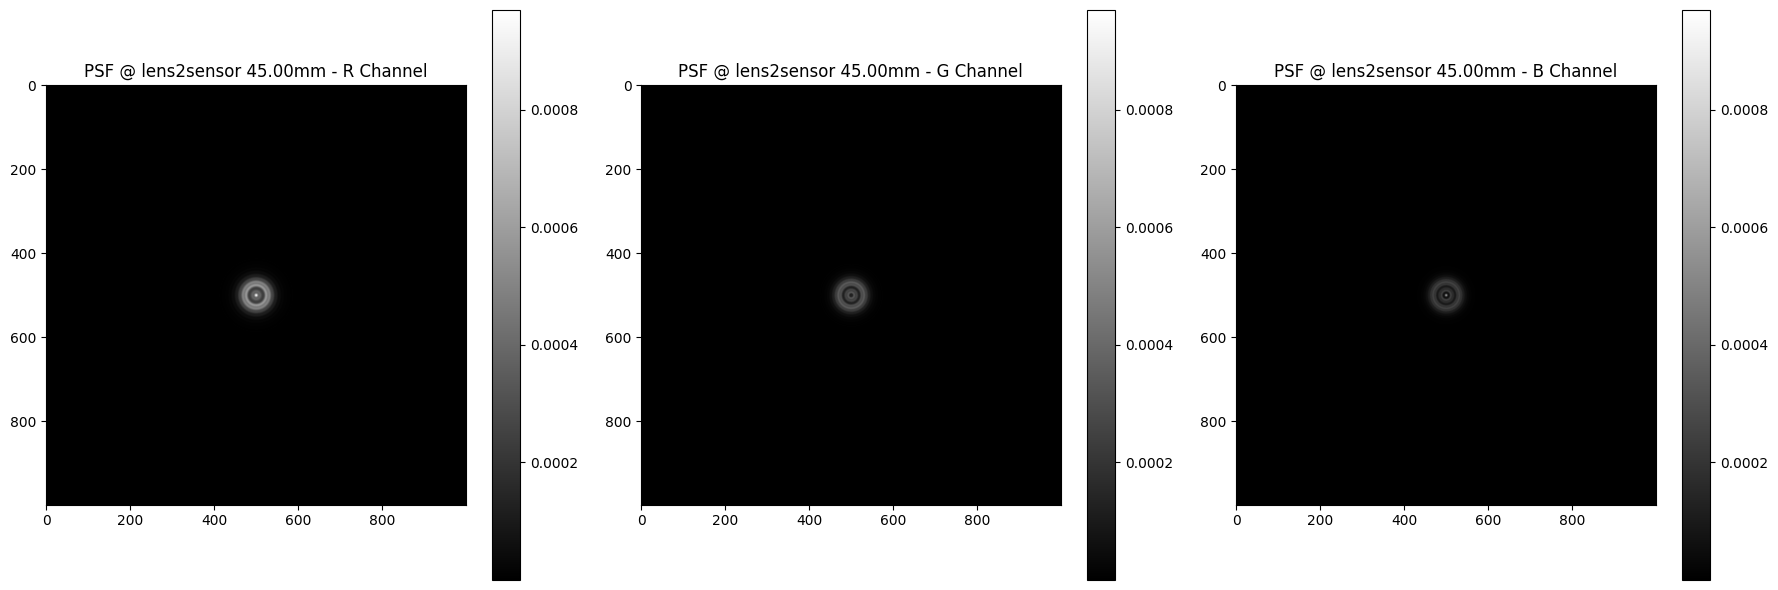

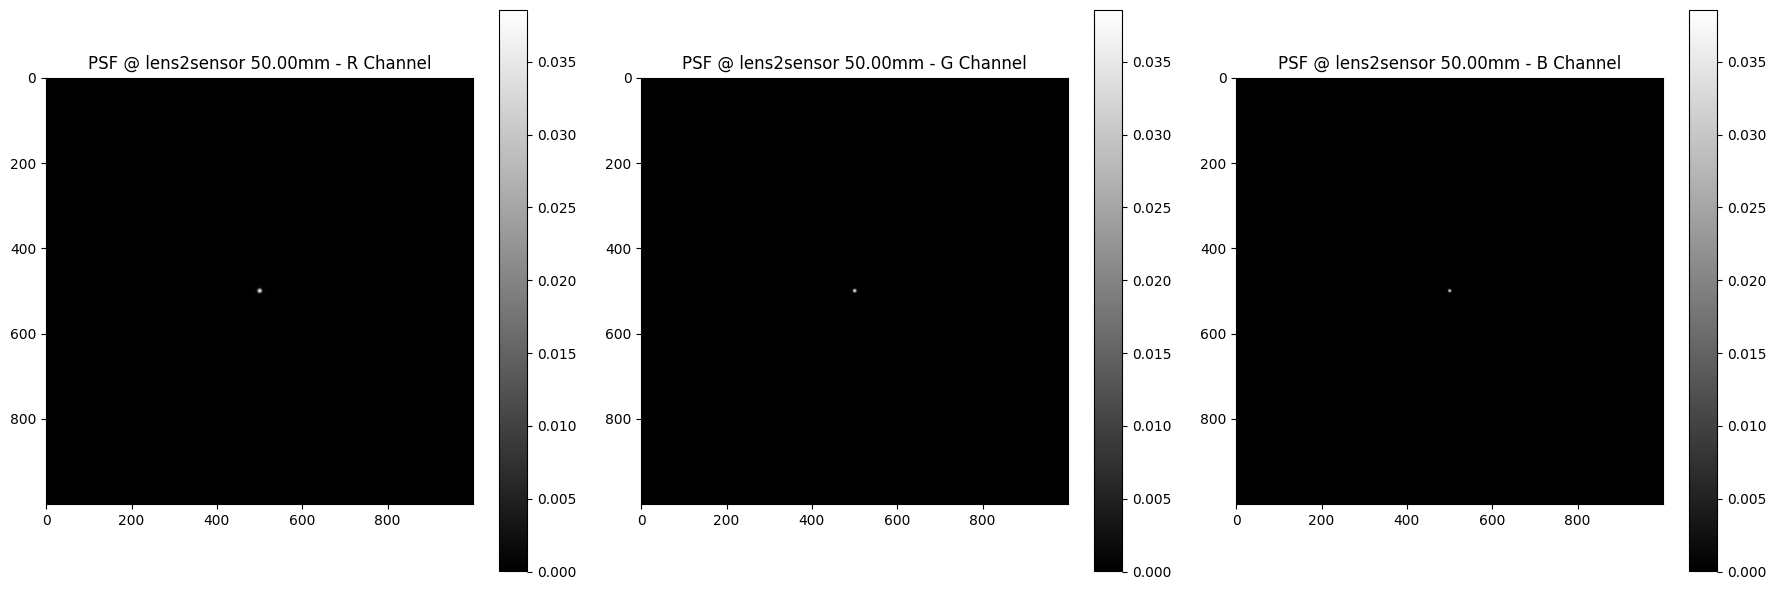

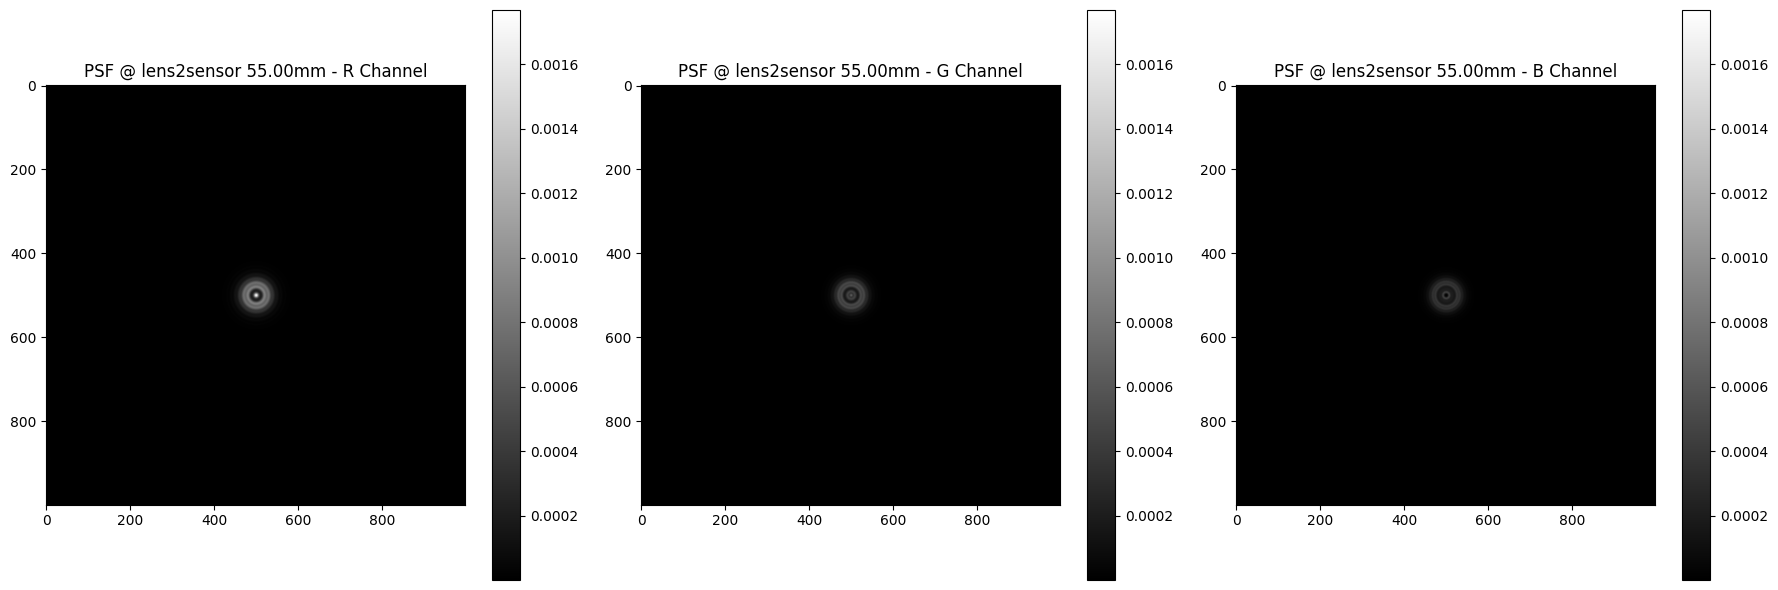

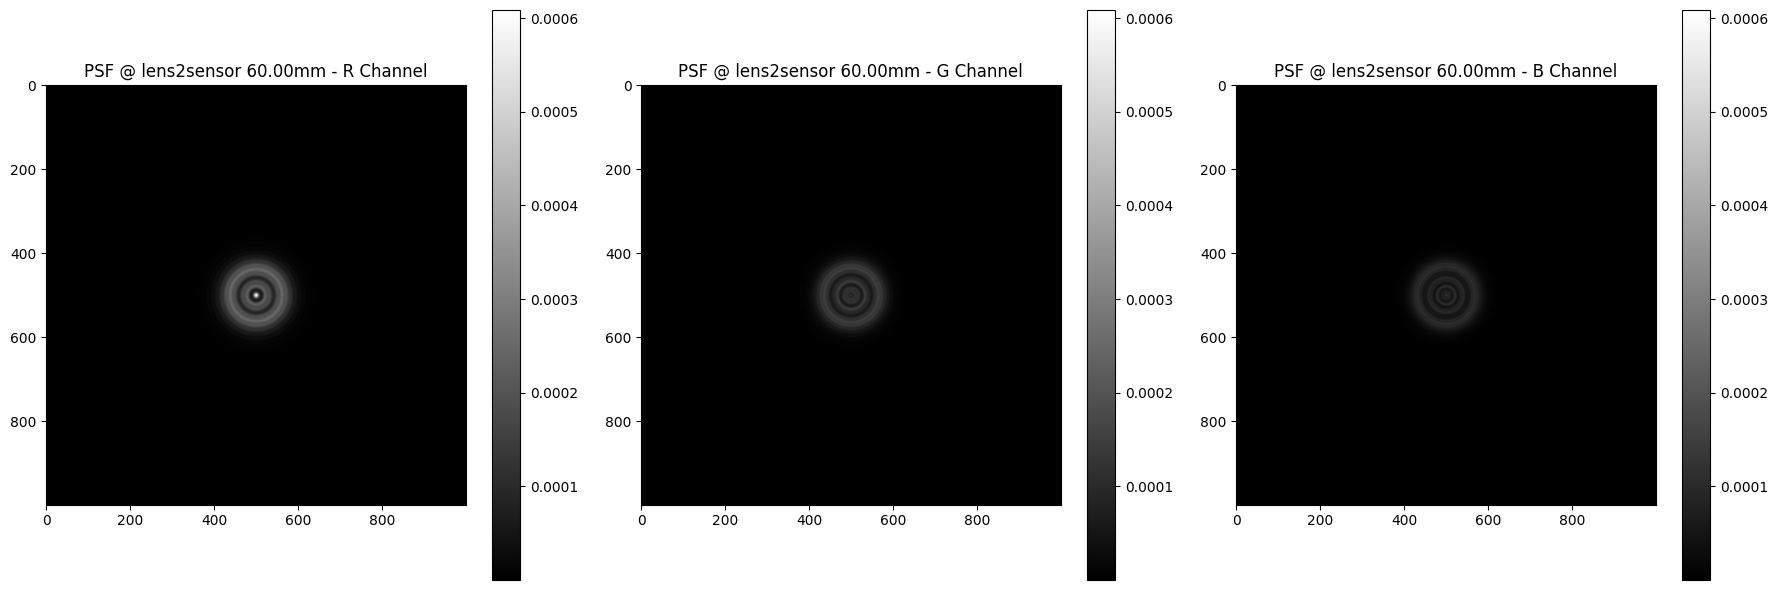

In [11]:
circular_aperture_change = aperture.get_amplitude_change()

for lens2sensor_d in torch.linspace(f-1e-2, f+1e-2, 5):
    PSF = render(lens2sensor_d, circular_aperture_change)

    channels = [('R', 0), ('G', 1), ('B', 2)]

    plt.figure(figsize=(18, 6))

    first_channel_PSF = PSF[:, channels[0][1], ...].data.cpu().squeeze()
    vmin, vmax = first_channel_PSF.min(), first_channel_PSF.max()

    for i, (color, idx) in enumerate(channels):
        plt.subplot(1, 3, i + 1)
        PSF_channel = PSF[:, idx, ...].data.cpu().squeeze()
        plt.imshow(PSF_channel, cmap='gray', vmin=vmin, vmax=vmax)
        plt.colorbar()
        plt.title(f'PSF @ lens2sensor {lens2sensor_d*1e3:.2f}mm - {color} Channel')

    plt.tight_layout()
    plt.show()


## **🔬 Step 5: Coded Aperture Imaging**
Now, let's test a coded-aperture configuration, which introduces a customized pattern to modulate the amplitude of light passing through the aperture. Unlike conventional circular apertures.

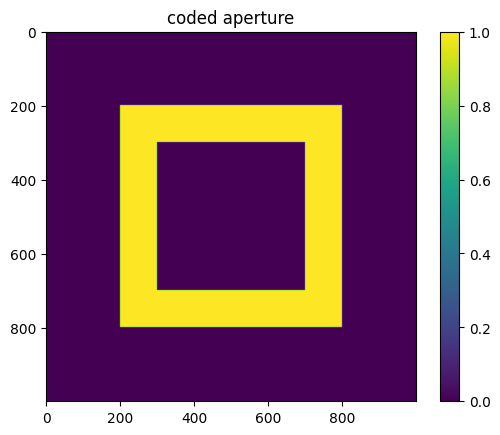

In [12]:
coded_pattern = torch.zeros((1,1,R,C), device=device)
thickness = 50
coded_pattern[0, 0, R//4-thickness:R//4+thickness, C//4-thickness:3*C//4+thickness] = 1
coded_pattern[0, 0, 3*R//4-thickness:3*R//4+thickness, C//4-thickness:3*C//4+thickness] = 1
coded_pattern[0, 0, R//4-thickness:3*R//4+thickness, C//4-thickness:C//4+thickness] = 1
coded_pattern[0, 0, R//4-thickness:3*R//4+thickness, 3*C//4-thickness:3*C//4+thickness] = 1
plt.figure()
plt.imshow(coded_pattern.data.cpu().numpy().squeeze())
plt.title('coded aperture')
plt.colorbar()

Again, we simulate the PSF for the coded-aperture camera

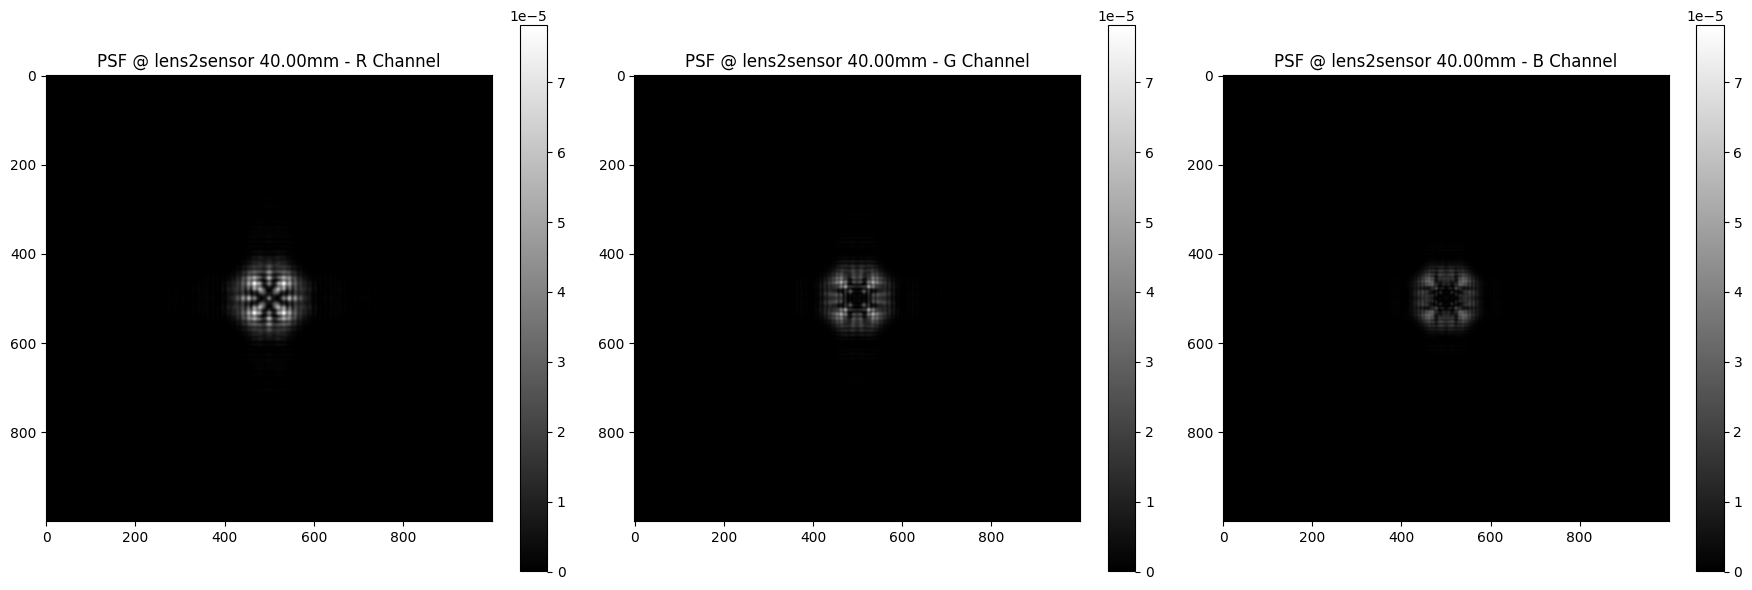

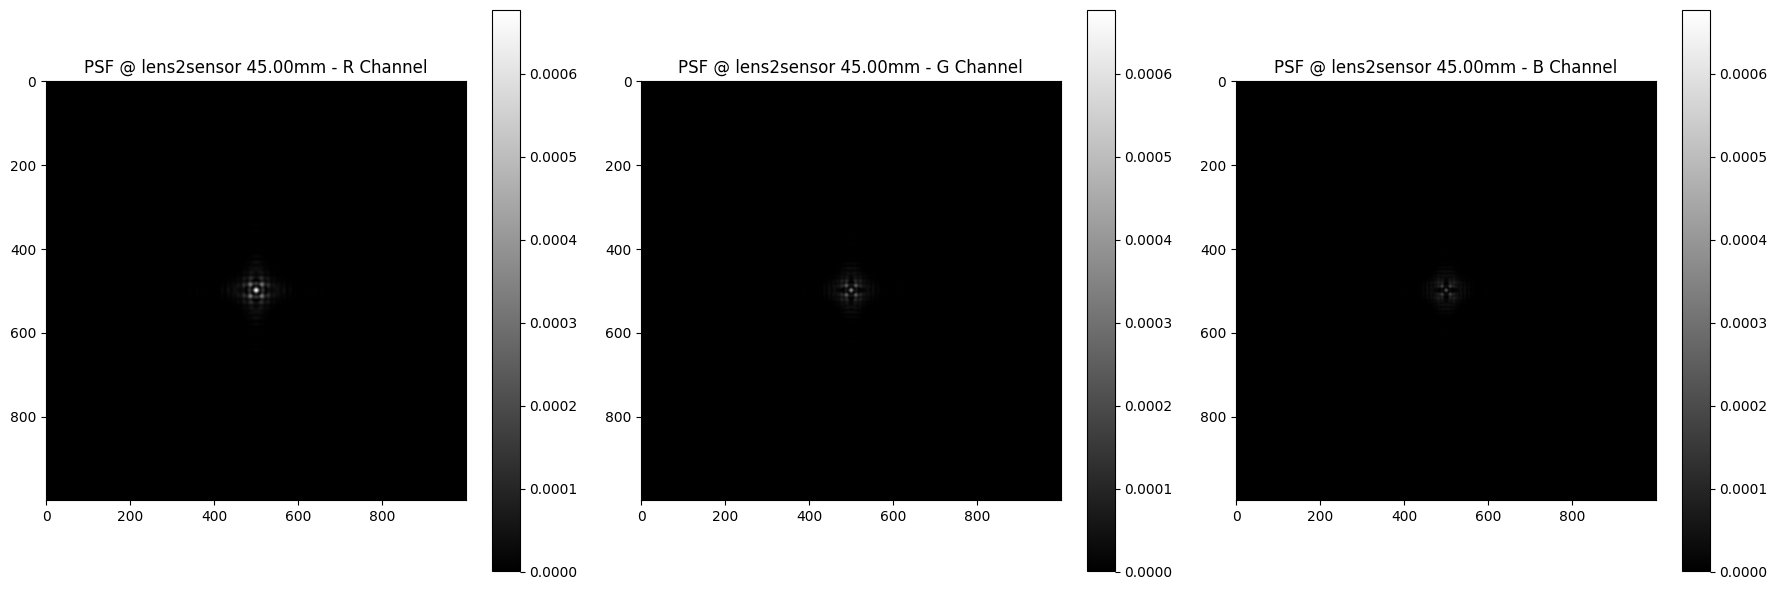

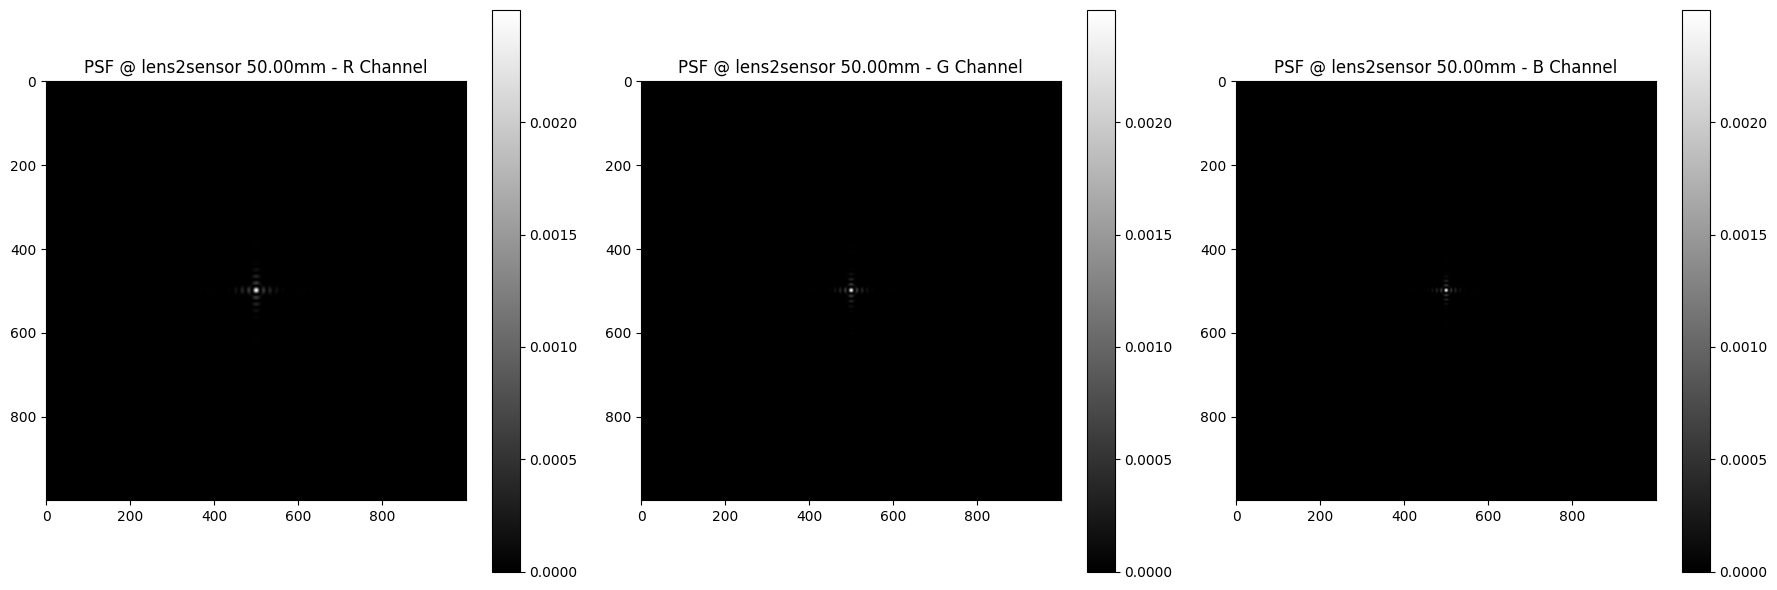

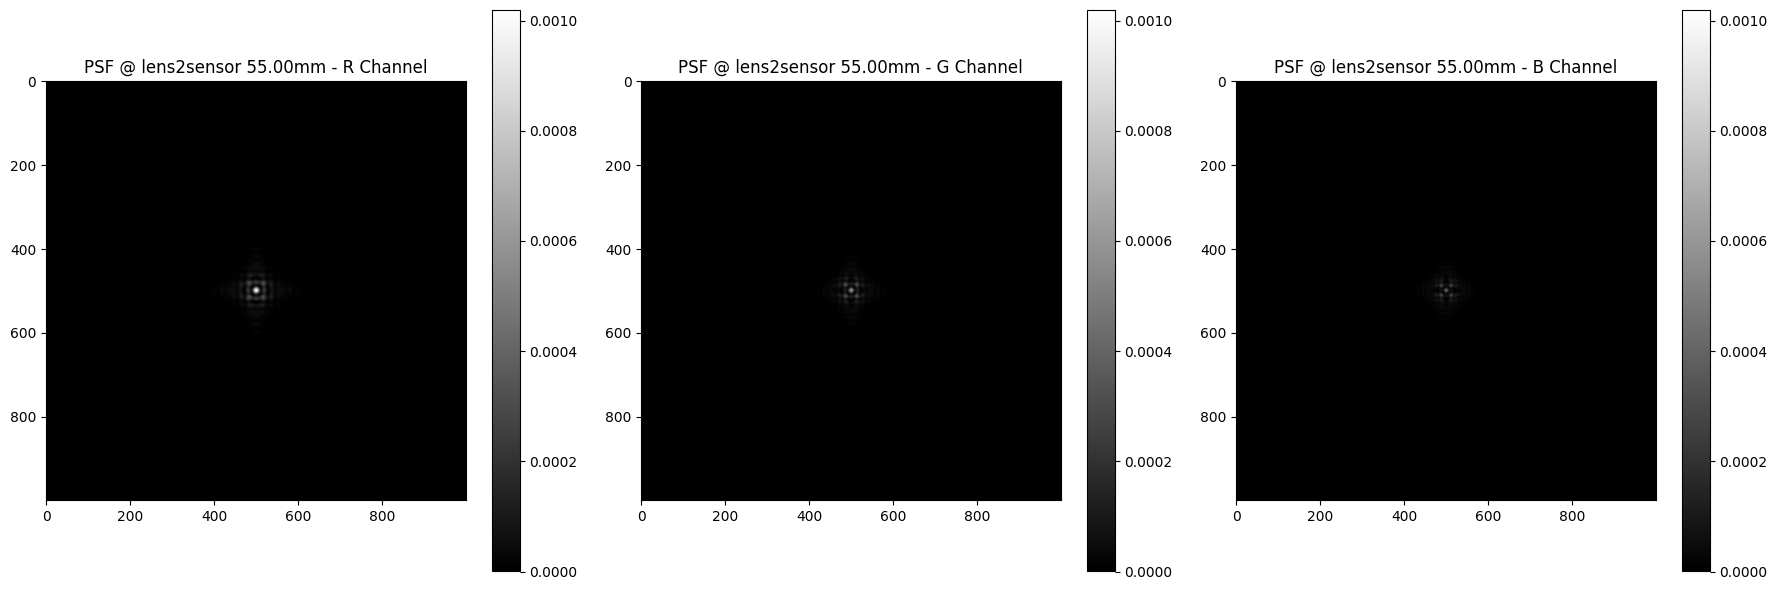

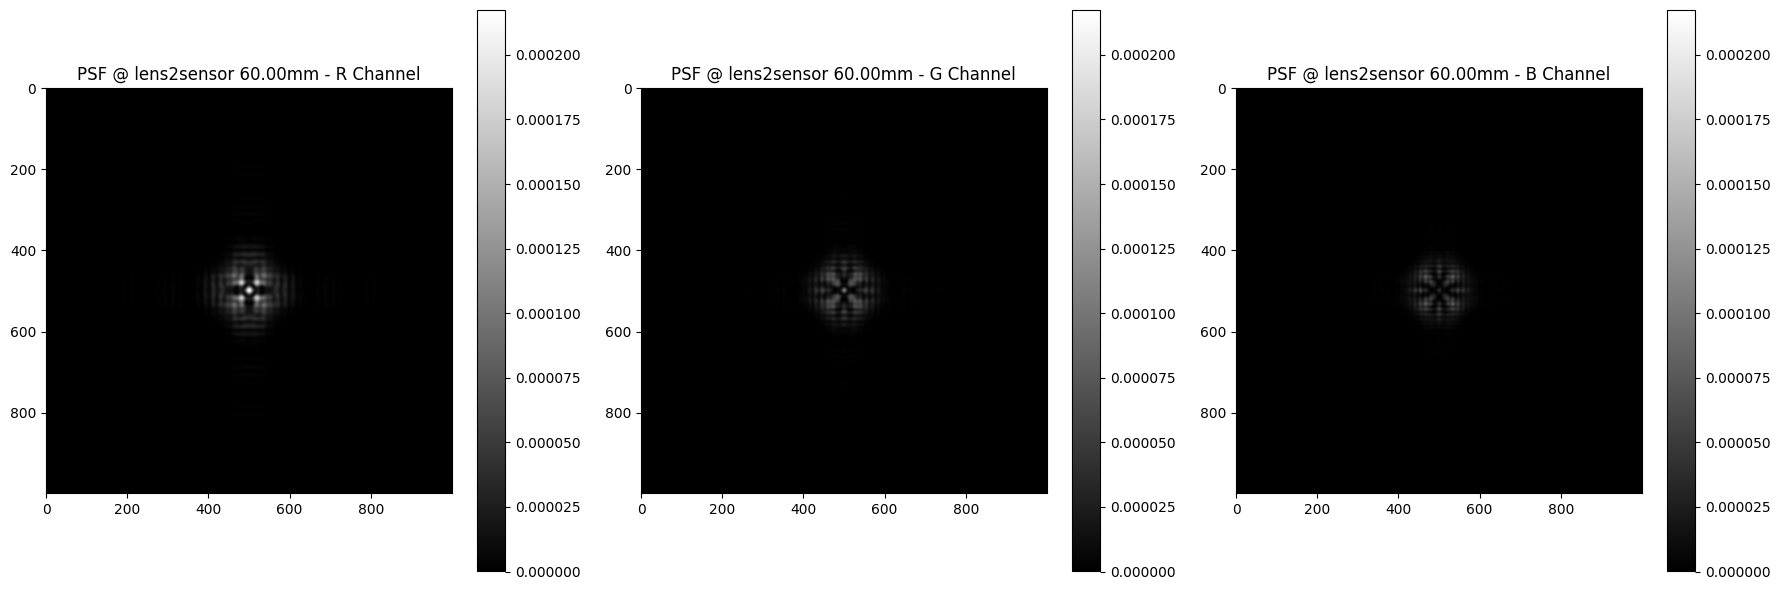

In [13]:
circular_aperture_change = aperture.get_amplitude_change()

for lens2sensor_d in torch.linspace(f-1e-2, f+1e-2, 5):
    PSF = render(lens2sensor_d, coded_pattern)

    channels = [('R', 0), ('G', 1), ('B', 2)]
    plt.figure(figsize=(18, 6))

    vmin = PSF[:, channels[0][1], ...].min()
    vmax = PSF[:, channels[0][1], ...].max()

    for i, (color, idx) in enumerate(channels):
        plt.subplot(1, 3, i + 1)
        PSF_channel = PSF[:, idx, ...].data.cpu().squeeze()
        plt.imshow(PSF_channel, cmap='gray', vmin=vmin.item(), vmax=vmax.item())
        
        plt.colorbar()
        plt.title(f'PSF @ lens2sensor {lens2sensor_d*1e3:.2f}mm - {color} Channel')

    plt.tight_layout()
    plt.show()
